# MURaM Atmosphere Statistics

In this notebook we look at some of the properties of the MURaM atmospheres.

In [1]:
import muram
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import sys

In [2]:
os.getpid() # for checking memory/CPU in terminal

286123

In [3]:
# Set the location of the MURaM data
dir2D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/2D"
dir3D = "/glade/p/hao/radmhd/rempel/Swirls/dyn_25x8Mm_16_pdmp_1_ext_zxy_pdm/3D"
iteration = 12000

## Mean Atmosphere

Below we compute the horizontally averaged atmosphere, in order to compare it to the standard FALC atmosphere.

Note: this goes over a lot of data and is slow.  An ugly, dirty trick is done to keep this procedure within memory limits.

In [4]:
def calc_means(iteration):
    snap = muram.MuramSnap(dir3D, iteration)

    # Build a height axis with 0 == tau1
    x = np.arange(snap.T.shape[0]) * 16. # km
    tau_mean = np.mean(snap.tau, axis=(1,2))
    tau1_ix = (np.abs(tau_mean - 1.0)).argmin()
    height = x - x[tau1_ix]

    names = ('height', 'T', 'P', 'rho', 'vx', 'vy', 'vz', 'v', 'Bx', 'By', 'Bz', 'B')
    formats = ['f'] * len(names)
    dtype = [x for x in zip(names, formats)]
    data = np.zeros(height.size, dtype=dtype)
    data['height'] = height
    
    # Note: this pulls a lot of data into memory
    # We delete the snapshot afterwards in order to return
    # resources to the shared cluster
    for var in ('T', 'P', 'rho', 'vx', 'vy', 'vz'):
        data[var] = np.mean(getattr(snap, var), axis=(1,2))
        delattr(snap, var) # clear memory
    for var in ('Bx', 'By', 'Bz'):
        data[var] = np.mean(getattr(snap, var), axis=(1,2)) * np.sqrt(4 * np.pi)
        delattr(snap, var) # clear memory

    data['v'] = np.sqrt(data['vx']**2 + data['vy']**2 + data['vz']**2)
    data['B'] = np.sqrt(data['Bx']**2 + data['By']**2 + data['Bz']**2)
    
    return data

means = calc_means(iteration)

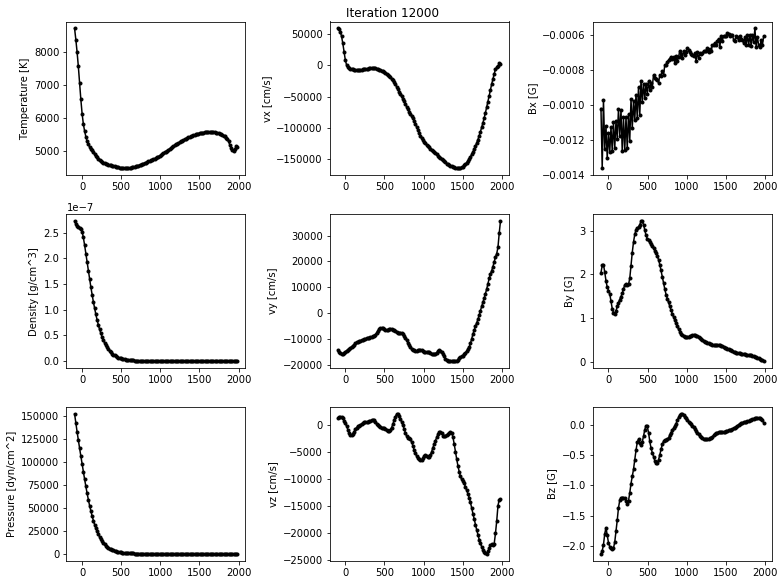

In [5]:
def plot_means(iteration, min_height=-100, close=False):
    means = calc_means(iteration)
    sel = means['height'] >= min_height

    fig, ((ax1, ax4, ax7), (ax2, ax5, ax8), (ax3, ax6, ax9)) = plt.subplots(3, 3, figsize=(11, 8.5))
    
    ax1.plot(means['height'][sel], means['T'][sel], 'k.-')
    ax1.set_ylabel('Temperature [K]')
    ax2.plot(means['height'][sel], means['rho'][sel], 'k.-')
    ax2.set_ylabel('Density [g/cm^3]')
    ax3.plot(means['height'][sel], means['P'][sel], 'k.-')
    ax3.set_ylabel('Pressure [dyn/cm^2]')

    ax4.plot(means['height'][sel], means['vx'][sel], 'k.-')
    ax4.set_ylabel('vx [cm/s]')
    ax5.plot(means['height'][sel], means['vy'][sel], 'k.-')
    ax5.set_ylabel('vy [cm/s]')
    ax6.plot(means['height'][sel], means['vz'][sel], 'k.-')
    ax6.set_ylabel('vz [cm/s]')

    ax7.plot(means['height'][sel], means['Bx'][sel], 'k.-')
    ax7.set_ylabel('Bx [G]')
    ax8.plot(means['height'][sel], means['By'][sel], 'k.-')
    ax8.set_ylabel('By [G]')
    ax9.plot(means['height'][sel], means['Bz'][sel], 'k.-')
    ax9.set_ylabel('Bz [G]')
    fig.suptitle(f"Iteration {iteration:5d}")
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    fig.savefig(f'mean_atmos_{iteration:5d}.png')
    if close:
        plt.close(fig)
    
plot_means(iteration)

### Iterate through all data cubes and plot mean atmosphere

In [6]:
cube_iterations = muram.cube_iterations(dir3D)
cube_iterations = np.array(cube_iterations)
cube_iterations = cube_iterations[cube_iterations > 10000]
len(cube_iterations)

100